# Lecture 16: Artificial Neural Networks (ANN)

MTU Spring 2024

Instructor: Abel Reyes

### Announcements

- HW7 on canvas, deadline: 03/27/24 by midnight
- HW6 grades in progress
- Quiz 3 this friday! (K-NN, and K-means)
- Midterm grading is in progress (yes, stills...).
- Final course project guidelines on canvas.

## Learning outcomes
- Explain the role of neural networks in machine learning, and the pros/cons of using them.
- Understand logistic regression as nn.
- No linealy separable function limitations with logistic regression
- Use of `keras`
- Explain why the methods we've learned previously would not be effective on image data.
- Apply pre-trained neural networks to classification and regression problems.


In [33]:
import mglearn

import glob
import copy
import os, sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_classification, make_moons, make_circles


from keras.optimizers import SGD


from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

## Introduction to neural networks

- Very popular these days under the name **deep learning**. 
- Neural networks apply a sequence of transformations on your input data.
- They can be viewed a generalization of linear models where we apply a series of transformations. 
- Here is graphical representation of a logistic regression model. 
    - We have 4 features: x[0], x[1], x[2], x[3]

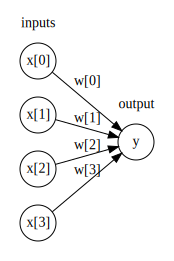

In [34]:

mglearn.plots.plot_logistic_regression_graph()

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

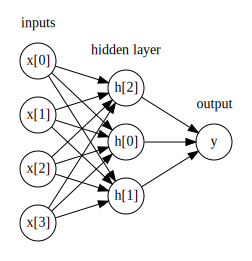

In [35]:
mglearn.plots.plot_single_hidden_layer_graph()

- Now we are adding one more layer of transformations. 

mglearn.plots.plot_two_hidden_layer_graph()

- At a very high level you can also think of them as `Pipelines` in `sklearn`. 
- A neural network is a model that's sort of like its own pipeline
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.

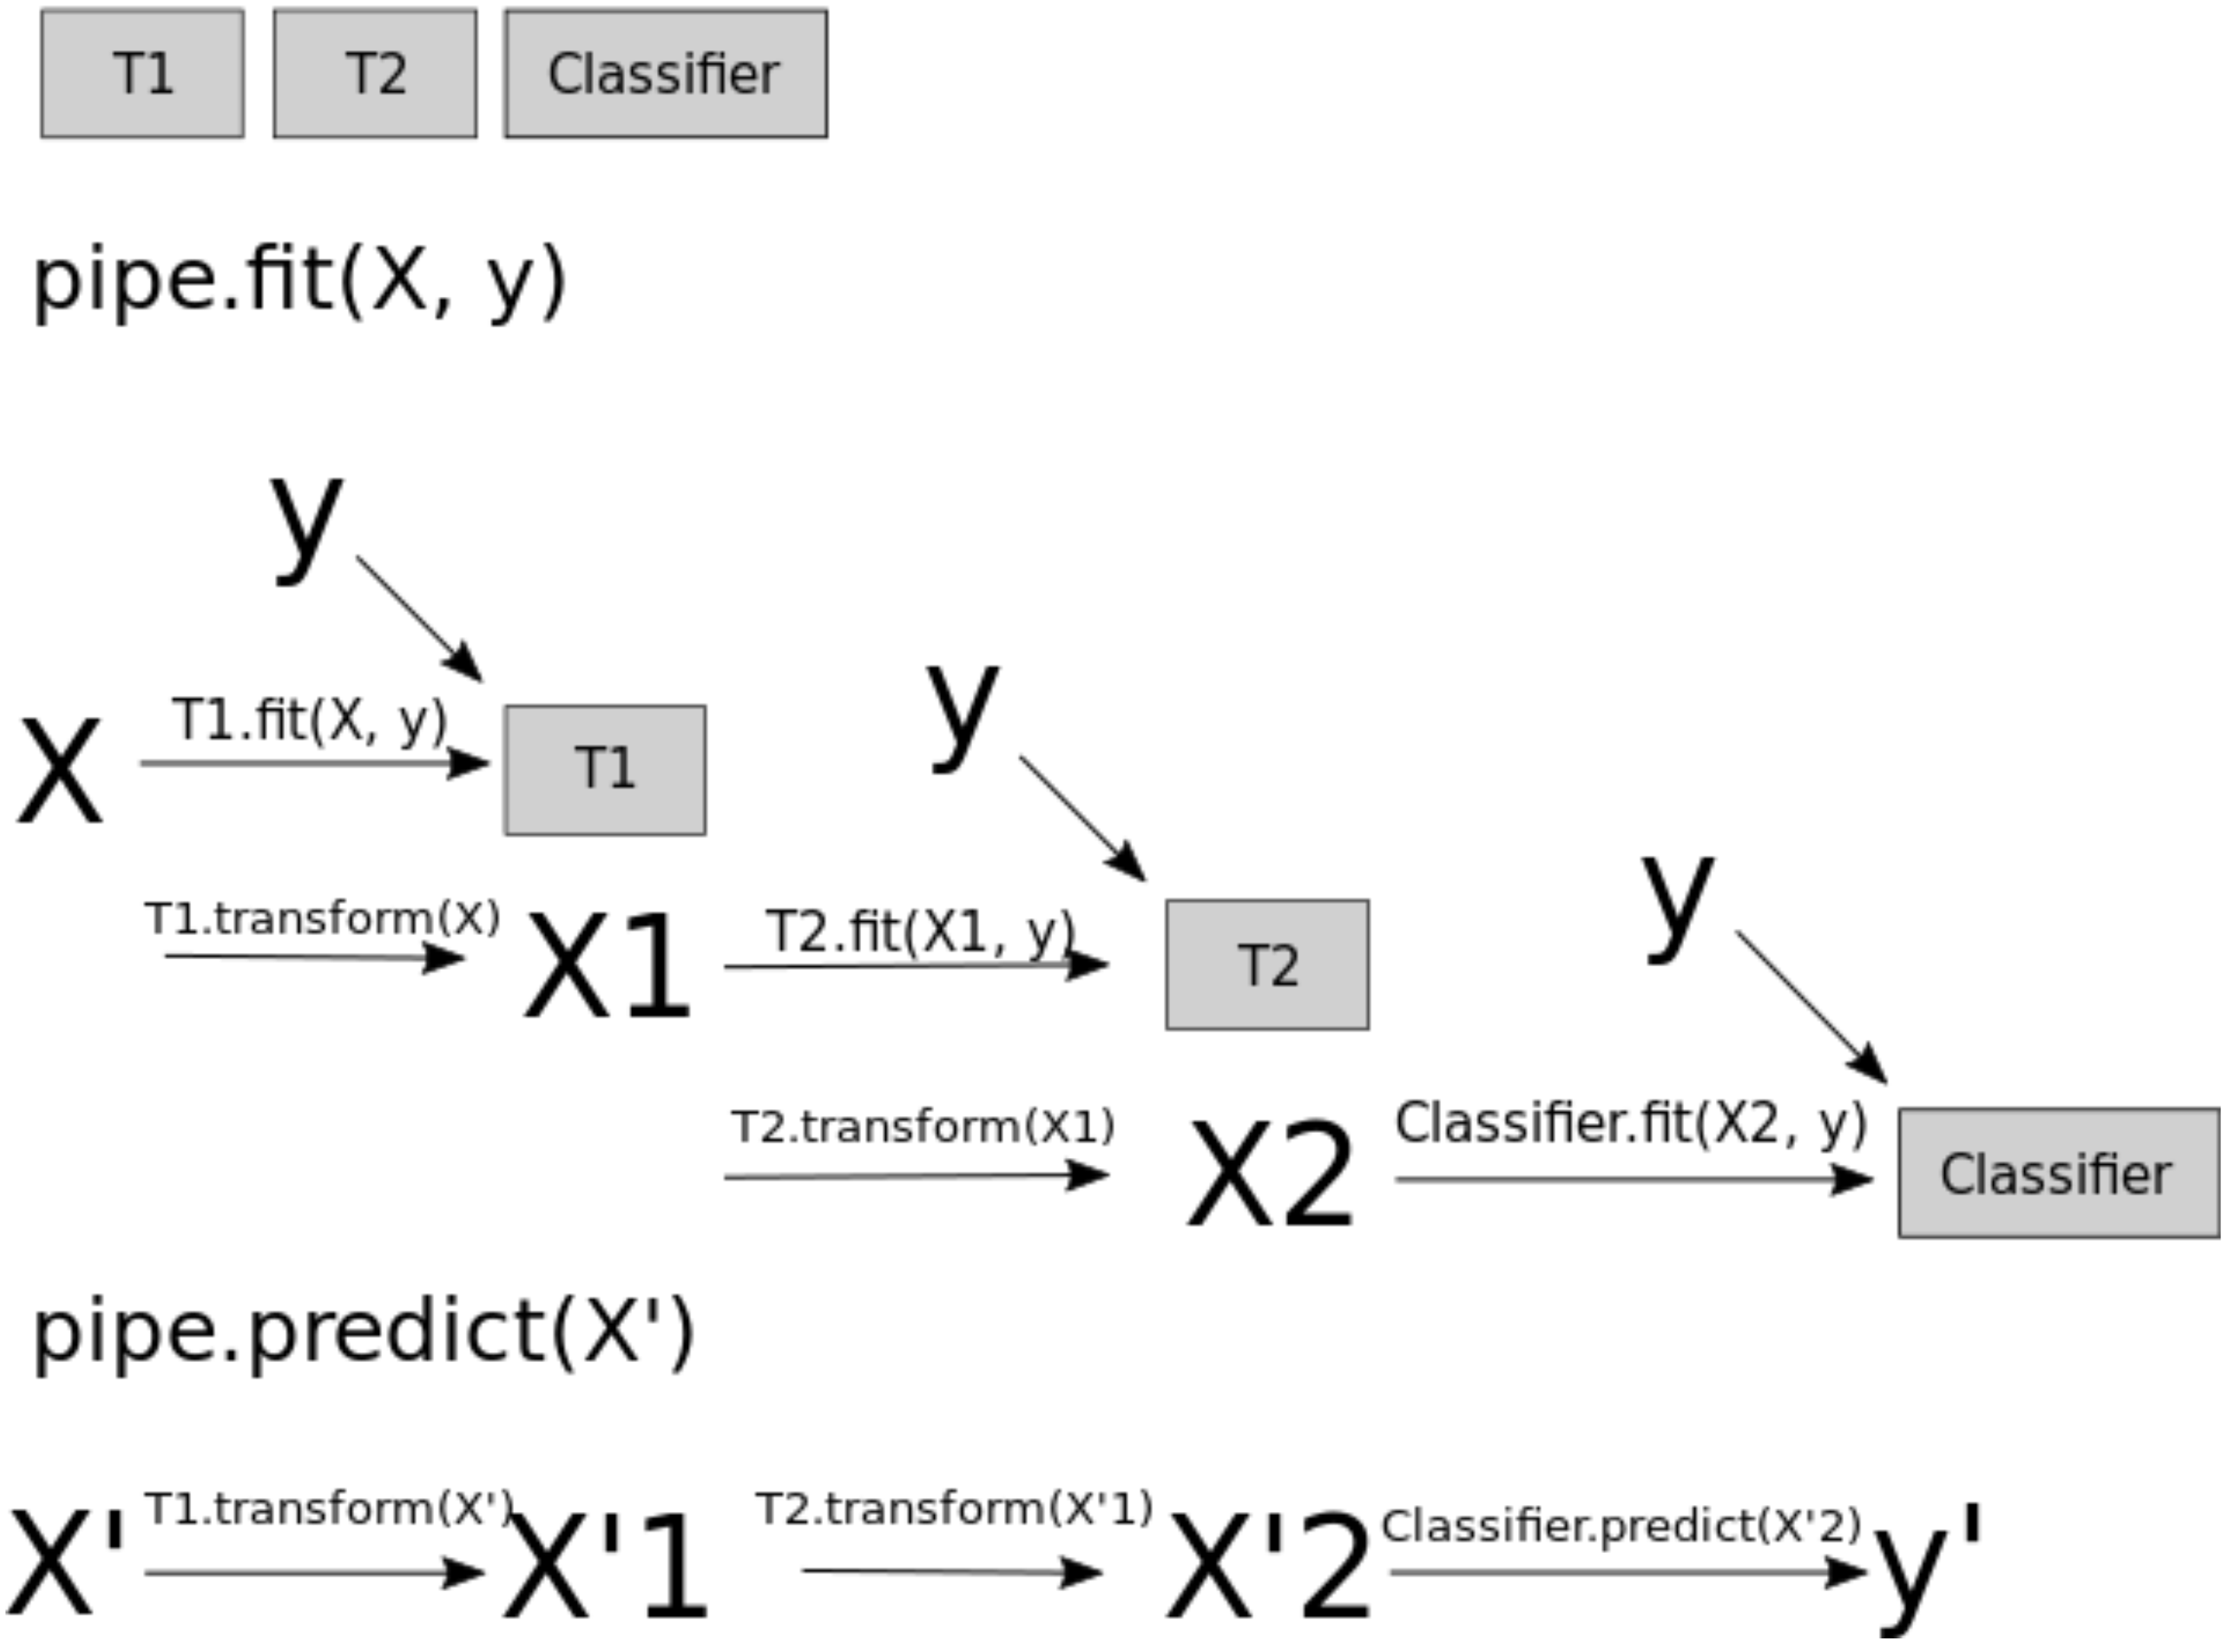

- Important question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 4 to 3 to 3 to 1.

- To make them really powerful compared to the linear models, we apply a non-linear function to the weighted sum for each hidden node. 

### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit. 

### Why neural networks?

- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable. (? not necesarely)

### Why not neural networks?

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them on your own without further training
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks without calling `fit`.

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

- The current big players are:

1. [PyTorch](http://pytorch.org)
2. [TensorFlow](https://www.tensorflow.org)

- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## One step back

### Limitations of linear models 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.

A few questions you might be thinking about
- How often the real-life data is linearly separable?
- Is the following XOR function linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    

- Are linear classifiers very limiting because of this?     

In [36]:
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()
    
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

    
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X, verbose=0)>0.5
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

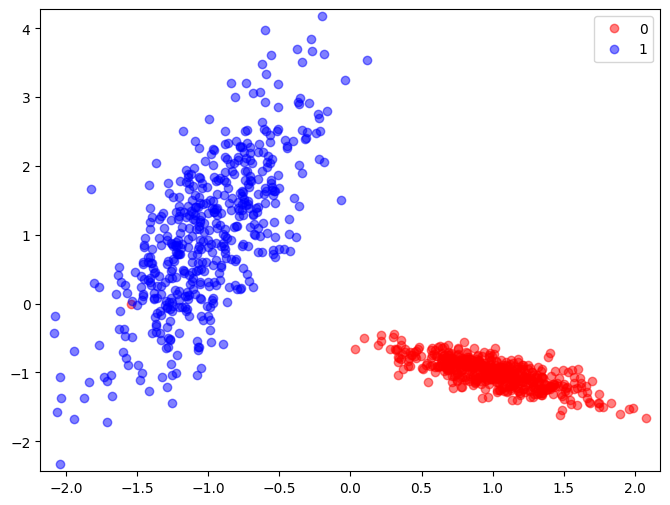

In [37]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

In [38]:
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

LR coefficients: [[-4.09049818  2.07274152]]
LR intercept: [-0.27800528]


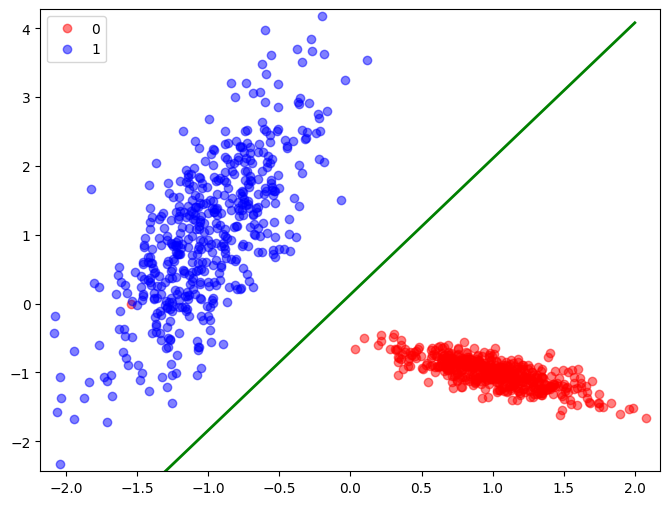

In [39]:
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

In [41]:

## Our first NN model
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=1, epochs=75)


Epoch 1/75
32/32 [==============================] - 0s 3ms/step - loss: 2.1720 - accuracy: 0.0370
Epoch 2/75
32/32 [==============================] - 0s 3ms/step - loss: 2.1157 - accuracy: 0.0370
Epoch 3/75
32/32 [==============================] - 0s 3ms/step - loss: 2.0599 - accuracy: 0.0370
Epoch 4/75
32/32 [==============================] - 0s 3ms/step - loss: 2.0049 - accuracy: 0.0380
Epoch 5/75
32/32 [==============================] - 0s 3ms/step - loss: 1.9507 - accuracy: 0.0390
Epoch 6/75
32/32 [==============================] - 0s 3ms/step - loss: 1.8967 - accuracy: 0.0410
Epoch 7/75
32/32 [==============================] - 0s 3ms/step - loss: 1.8437 - accuracy: 0.0420
Epoch 8/75
32/32 [==============================] - 0s 3ms/step - loss: 1.7913 - accuracy: 0.0440
Epoch 9/75
32/32 [==============================] - 0s 3ms/step - loss: 1.7396 - accuracy: 0.0450
Epoch 10/75
32/32 [==============================] - 0s 3ms/step - loss: 1.6889 - accuracy: 0.0450
Epoch 11/75
32/32 [

In [42]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


<Figure size 800x600 with 0 Axes>

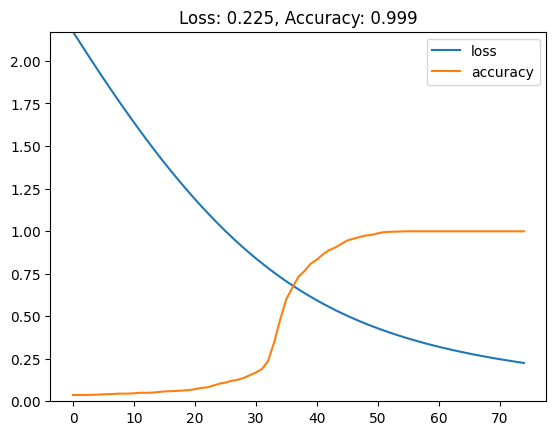

In [43]:
plot_loss_accuracy(history)

319/319 [==============================] - 0s 1ms/step


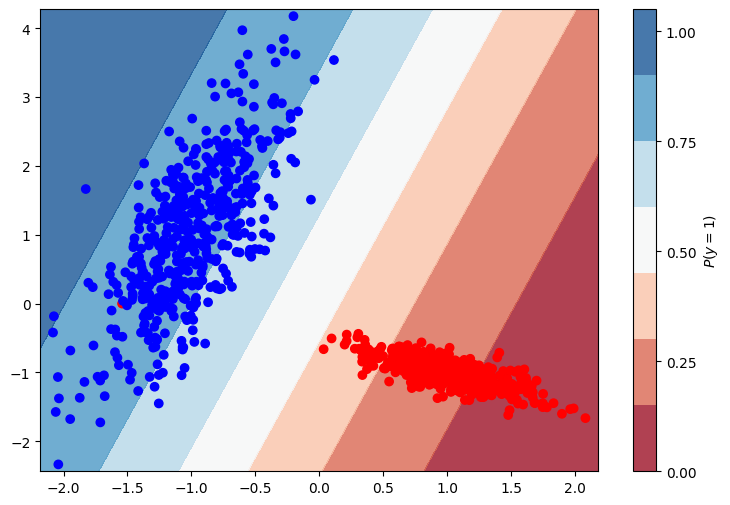

In [44]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


In [45]:
y_pred = model.predict(X, verbose=0)>0.5

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       501
           1       1.00      1.00      1.00       499

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



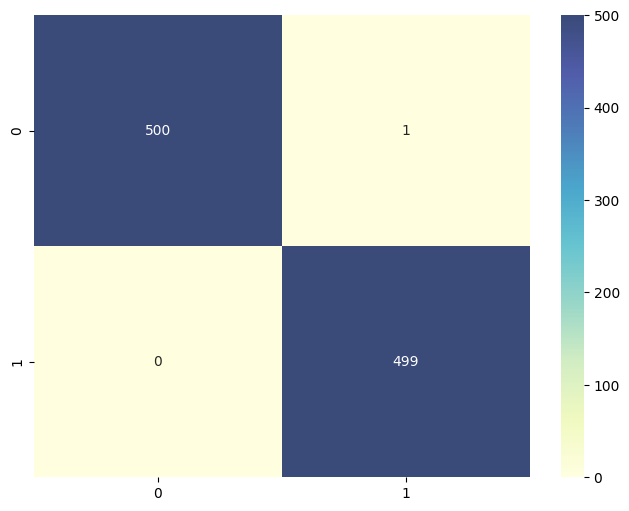

In [46]:
plot_confusion_matrix(model, X, y)


### Complex data - moons
The previous dataset was linearly separable, so it was trivial for our logistic regression model to separate the classes. Here is a more complex dataset which isn't linearly separable. The simple logistic regression model won't be able to distinguish between the classes.

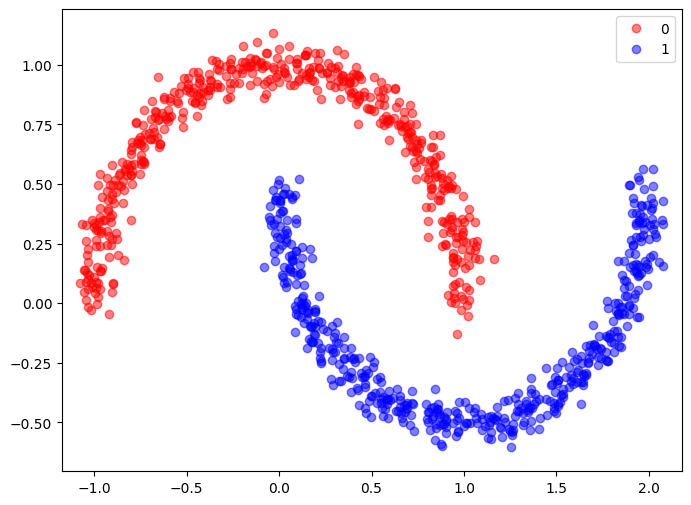

In [47]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

We're building the another logistic regression model with the same parameters as we did before.



<Figure size 800x600 with 0 Axes>

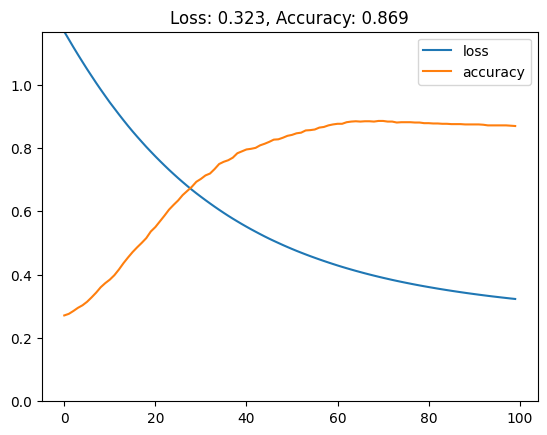

In [48]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

319/319 [==============================] - 0s 953us/step


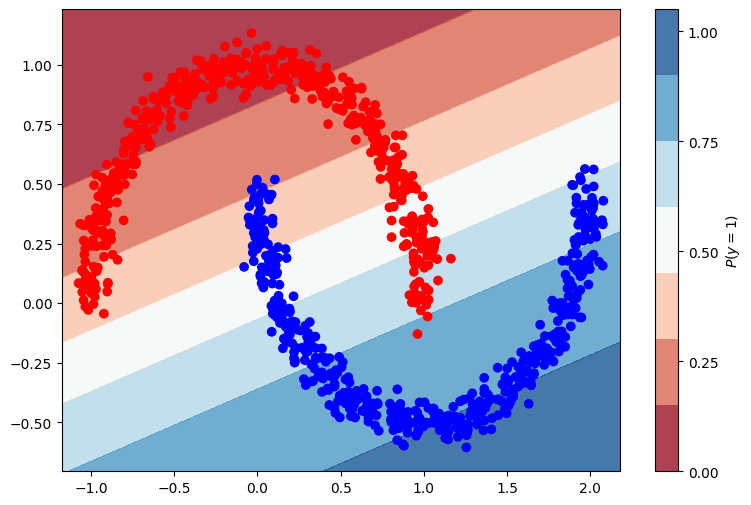

In [49]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


Precision of the model is 86%. It looks good on paper but we should be able to get 100% with a more complex model. You can imagine a curved decision boundary that will separate out the classes, and a complex model should be able to approximate that.

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       500
           1       0.87      0.87      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



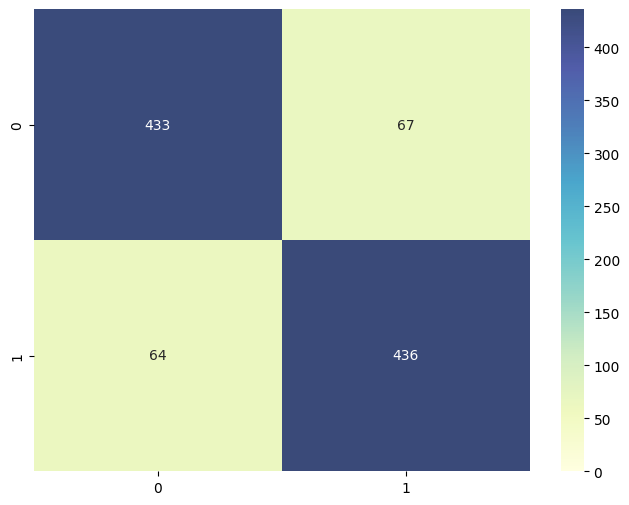

In [50]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

### Complex Data - Circles
Let's look at one final example where the liner model will fail.

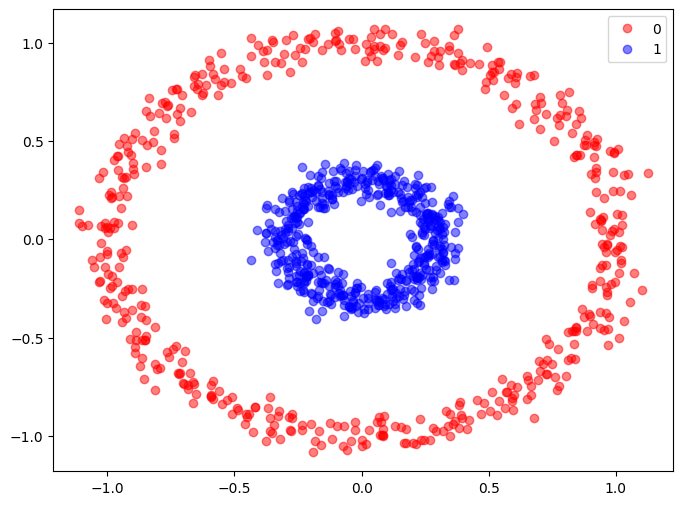

In [51]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

Building the model with same parameters.



<Figure size 800x600 with 0 Axes>

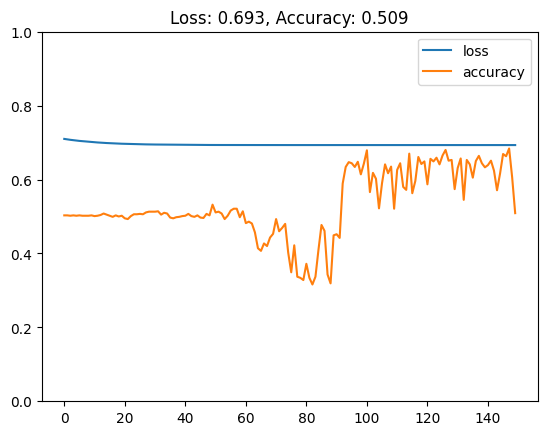

In [52]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=150)
plot_loss_accuracy(history)

The decision boundary again passes from the middle of the data, but now we have much more misclassified points.



319/319 [==============================] - 0s 884us/step


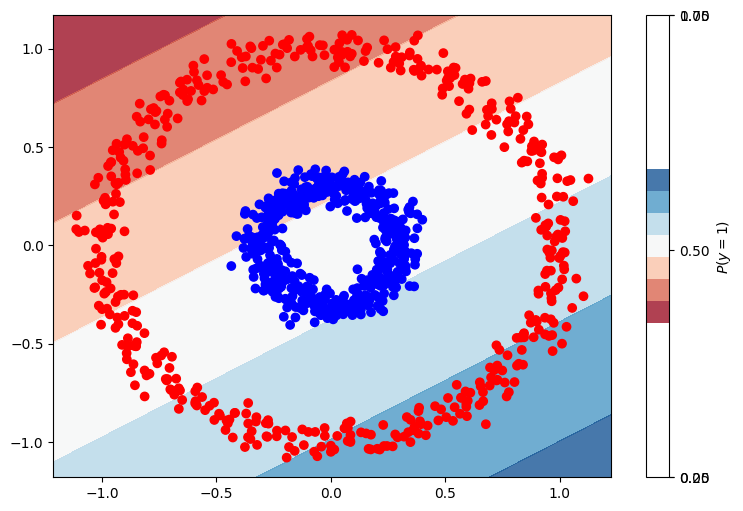

In [53]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


The accuracy is 51%. No matter where the model draws the linear line, it will misclassify half of the points, due to the nature of the dataset.

The confusion matrix we see here is an example one belonging to a poor classifier. Ideally we want confusion matrices like the ones we saw above. High numbers along the diagonals meaning that the classifier was right, and low numbers everywhere else where the classifier was wrong. In our visualization, the color blue represents the high numbers and yellow represents the low ones. So we would prefer to see blue on the diagonals and yellow everywhere else, blues everywhere is a bad sign meaning that our classifier is confused.

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       500
           1       0.51      0.54      0.53       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



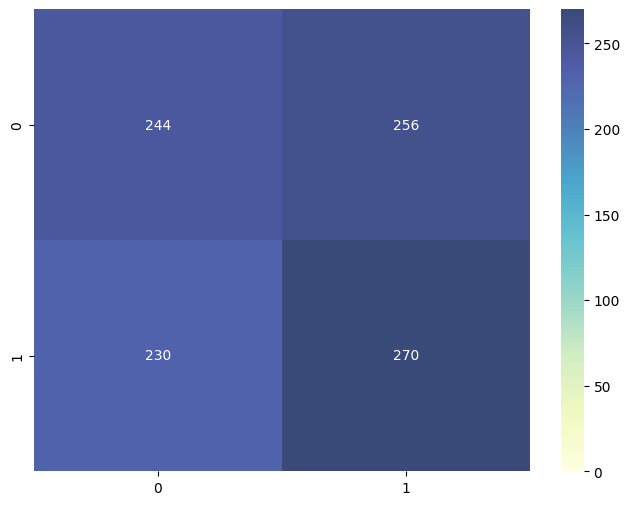

In [54]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Artificial Neural Networks (ANN)
Now we will train a deep Artificial Neural Networks (ANN) to better classify the datasets which the logistic regression model struggled, Moons and Circles. 

While building Keras models for logistic regression above, we performed the following steps:

- Step 1: Define a Sequential model.
- Step 2: Add a Dense layer with sigmoid activation function. This was the only layer we needed.
- Step 3: Compile the model with an optimizer and loss function.
- Step 4: Fit the model to the dataset.
- Step 5: Analyze the results: plotting loss/accuracy curves, plotting the decision boundary, looking at the classification report, and understanding the confusion matrix.

While building a deep neural network, we only need to change step 2 such that, we will add several Dense layers one after another. The output of one layer becomes the input of the next. Keras again does most of the heavy lifting by initializing the weights and biases, and connecting the output of one layer to the input of the next. We only need to specify how many nodes we want in a given layer, and the activation function. It’s as simple as that.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<Figure size 800x600 with 0 Axes>

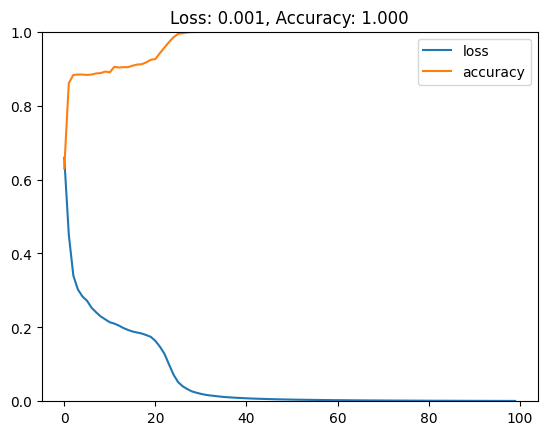

In [55]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

In [56]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 4)                 12        
                                                                 
 dense_16 (Dense)            (None, 2)                 10        
                                                                 
 dense_17 (Dense)            (None, 1)                 3         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


As you can see we first add a layer with 4 nodes and tanh activation function. Tanh is a commonly used activation function, and we'll learn more about it in another tutorial. We then add another layer with 2 nodes and again tanh activation. We finally add the last layer with 1 node and sigmoid activation. This is the final layer that we also used in the logistic regression model.

This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:

Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.
We didn't build a very deep ANN here because it wasn't necessary. We already achieve perfect accuracy with this configuration.

The ANN is able to come up with a perfect separator to distinguish the classes.



319/319 [==============================] - 0s 1ms/step


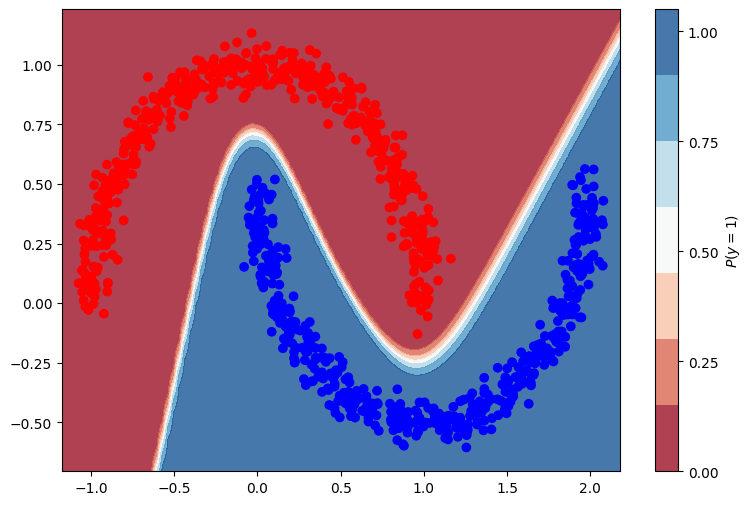

In [57]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


100% precision, nothing misclassified.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



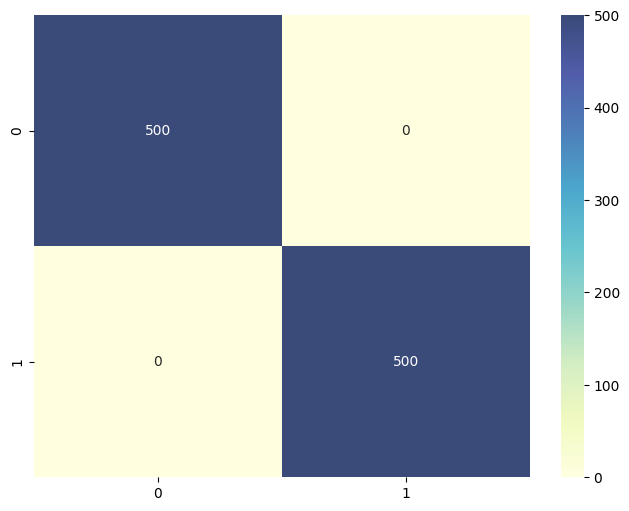

In [58]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

### Complex Data - Circles

Now let's look at the Circles dataset, where the LR model achieved only 50% accuracy. The model is the same as above, we only change the input to the fit function. And we again achieve 100% accuracy.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<Figure size 800x600 with 0 Axes>

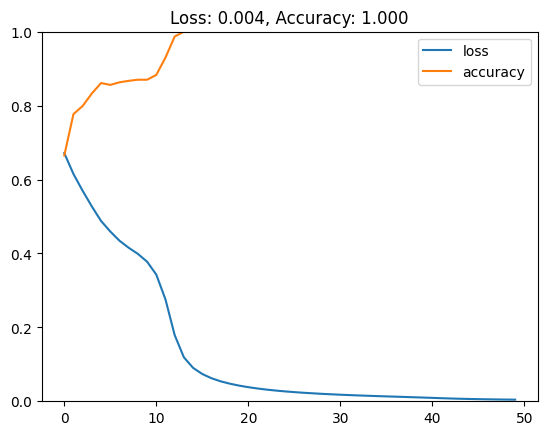

In [59]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

Similarly the decision boundary looks just like one we would draw by hand ourselves. The ANN was able to figure out an optimal separator.

319/319 [==============================] - 0s 1ms/step


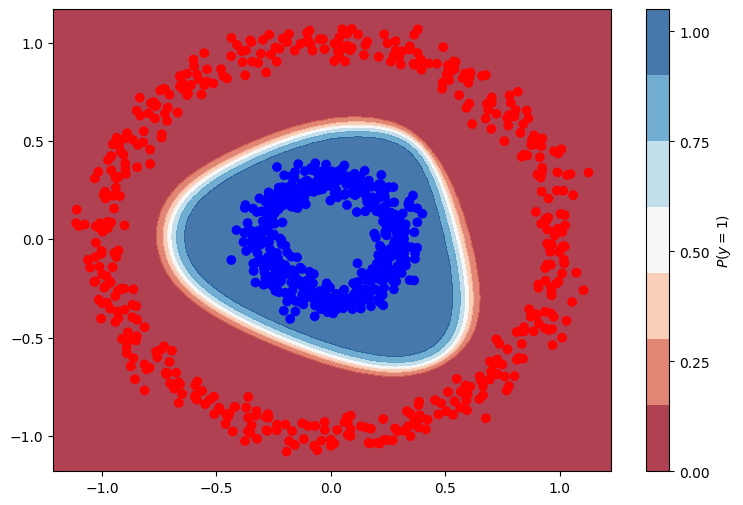

In [60]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


Just like above we get 100% accuracy.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



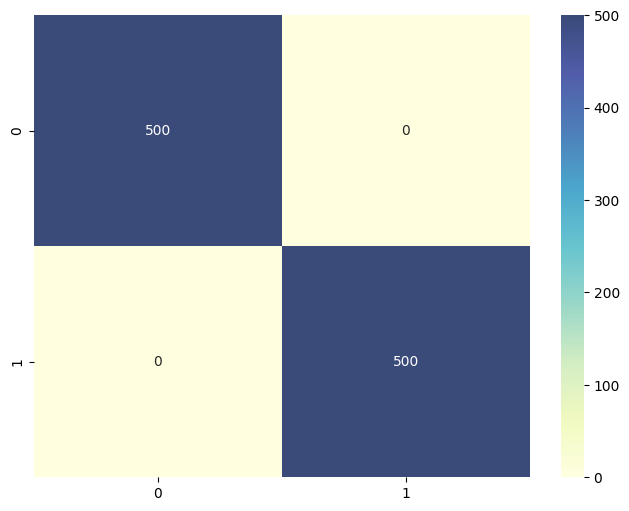

In [61]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## BTW, the XOR function as nn

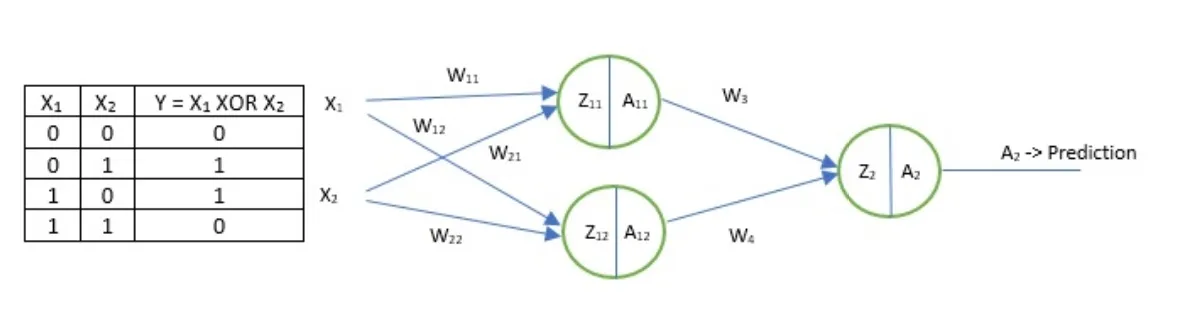

In [66]:


X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

model = Sequential()
model.add(Dense(2, input_dim=2))
model.add(Activation('tanh'))##tanh
model.add(Dense(1))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd)

model.fit(X, y, batch_size=1, epochs=1000)


Epoch 1/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7648
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7551
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7508
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7455
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7401
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7363
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7313
Epoch 8/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7277
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7251
Epoch 10/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7225
Epoch 11/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7196
Epoch 12/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7172
Epoch 13/1000
4/4 [==============================

4/4 [==============================] - 0s 2ms/step - loss: 0.5852
Epoch 104/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5844
Epoch 105/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5830
Epoch 106/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5817
Epoch 107/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5809
Epoch 108/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5802
Epoch 109/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5792
Epoch 110/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5783
Epoch 111/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5773
Epoch 112/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5758
Epoch 113/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5750
Epoch 114/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5741
Epoch 115/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.4533
Epoch 205/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4488
Epoch 206/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4440
Epoch 207/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4398
Epoch 208/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4337
Epoch 209/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4282
Epoch 210/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4225
Epoch 211/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4168
Epoch 212/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4118
Epoch 213/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4049
Epoch 214/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3993
Epoch 215/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3922
Epoch 216/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0919
Epoch 306/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0909
Epoch 307/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0900
Epoch 308/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0891
Epoch 309/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0883
Epoch 310/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 311/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 312/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0857
Epoch 313/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 314/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0841
Epoch 315/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0833
Epoch 316/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0826
Epoch 317/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 407/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0440
Epoch 408/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0438
Epoch 409/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 410/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 411/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 412/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 413/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0427
Epoch 414/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 415/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 416/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 417/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 418/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 508/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 509/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0285
Epoch 510/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0284
Epoch 511/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0283
Epoch 512/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 513/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 514/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 515/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 516/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 517/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 518/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 519/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 610/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 611/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 612/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 613/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 614/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 615/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 616/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 617/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 618/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 619/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 620/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 710/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 711/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 712/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 713/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 714/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 715/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 716/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 717/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 718/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 719/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 720/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 721/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 811/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 812/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 813/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 814/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 815/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 816/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 817/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 818/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 819/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 820/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 821/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 822/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 912/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 913/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 914/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 915/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 916/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 917/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 918/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 919/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 920/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 921/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 922/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 923/1000
4/4 [=======================

In [67]:
print(model.predict(X)>0.5)

1/1 [==============================] - 0s 39ms/step
[[False]
 [ True]
 [ True]
 [False]]


In [69]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())


{'name': 'dense_23', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 2, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 3.6410346,  3.2776144],
       [-3.688636 , -3.129211 ]], dtype=float32), array([-1.7798802,  1.4835488], dtype=float32)]
{'name': 'activation_4', 'trainable': True, 'dtype': 'float32', 'activation': 'tanh'} []
{'name': 'dense_24', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint'

[more detailed implementation](https://www.geeksforgeeks.org/implementation-of-artificial-neural-network-for-xor-logic-gate-with-2-bit-binary-input/)

In [65]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 2)                 6         
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
 dense_22 (Dense)            (None, 1)                 3         
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


### Pytorch

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        # Define the first layer (2 inputs, 2 neurons)
        self.fc1 = nn.Linear(2, 2)
        # Define the second layer (2 inputs, 1 output)
        self.fc2 = nn.Linear(2, 1)
        # Define an activation function
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = XORNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# XOR training data and labels
X = torch.tensor([[0.,0.], [0.,1.], [1.,0.], [1.,1.]], requires_grad=True)
Y = torch.tensor([[0.], [1.], [1.], [0.]])

# Training loop
for epoch in range(1000):
    # Forward pass: Compute predicted y by passing x to the model
    Y_pred = model(X)

    # Compute and print loss
    loss = criterion(Y_pred, Y)
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/1000], Loss: {:.4f}'.format(epoch+1, loss.item()))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Test the model
with torch.no_grad():
    Y_test = model(X)
    print("Predicted values: \n", Y_test>0.5)

Epoch [100/1000], Loss: 0.0035
Epoch [200/1000], Loss: 0.0011
Epoch [300/1000], Loss: 0.0006
Epoch [400/1000], Loss: 0.0004
Epoch [500/1000], Loss: 0.0003
Epoch [600/1000], Loss: 0.0002
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001
Predicted values: 
 tensor([[False],
        [ True],
        [ True],
        [False]])
